In [82]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [83]:
#from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

### Data Loading

In [84]:
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))

In [85]:
from funcs.data_read import (
    read_txn_data, 
    read_ob_data,
)

from funcs.preprocess import (
    preprocess_ob_data, 
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)


In [86]:
ob_data=read_ob_data(test=True,test_size=2)
trx_data=read_txn_data(test=True,test_size=2)
# preprocess the data
preprocess_trx_data=preprocess_trx_data(trx_data,"5min")
preprocess_ob_data=preprocess_ob_data(ob_data,freq="5min")
# create features 
ob_features=create_features_order_book(preprocess_ob_data)
trx_features=create_features_trx(preprocess_trx_data)


Processing 2 file(s): ['C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_07_2018.zip', 'C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_08_2018.zip']
Processing bitstamp_ob_04_07_2018.zip...
Processing bitstamp_ob_04_08_2018.zip...
Finished loading. Total rows: 49,188,752
Side column standardized successfully.
Timestamp ID created successfully.
TRX data resampled to 5min frequency - 38017 transactions grouped into common time windows
Missing values handled successfully.
TRX Data Preprocessed Successfully.
Timestamp ID created successfully.
Resampled OB data to 5min frequency. Selected 4918860 rows.
Missing values handled successfully.
OB Data Preprocessed Successfully.


In [87]:
ob_features

,timestamp_id,datetime,mid_price,spread,ask_volume,bid_volume,volume_imbalance,ask_slope_10pct,ask_slope_1pct,ask_slope_5pct,bid_slope_10pct,bid_slope_1pct,bid_slope_5pct,slope_imbalance_10pct,slope_imbalance_1pct,slope_imbalance_5pct
0,1530655474,2018-07-03 22:04:34+00:00,6611.895,5.87,2497.541916,567126.769785,564629.227869,1003.547817,317.156398,834.039734,1690.065971,263.047038,981.211775,686.518153,54.109360,147.172041
1,1530655774,2018-07-03 22:09:34+00:00,6617.420,1.12,2486.359822,567134.623144,564648.263322,992.990295,322.213788,824.110509,1697.339460,244.968080,975.169364,704.349165,77.245708,151.058855
2,1530656074,2018-07-03 22:14:34+00:00,6608.695,4.31,2506.696883,567135.993855,564629.296973,1012.724015,336.712405,842.590582,1753.454619,264.657267,990.537096,740.730605,72.055138,147.946514
3,1530656374,2018-07-03 22:19:34+00:00,6606.220,5.04,2495.223606,567141.604644,564646.381038,1001.092725,284.582178,831.030124,1759.105408,287.466218,996.147884,758.012682,2.884040,165.117760
4,1530656674,2018-07-03 22:24:34+00:00,6597.420,7.14,2514.452154,567133.911995,564619.459841,1031.934433,313.983889,847.275419,1751.626559,293.526621,1009.512850,719.692126,20.457268,162.237432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1533418774,2018-08-04 21:39:34+00:00,7010.680,2.66,3465.881312,609750.948539,606285.067227,850.419458,204.204726,532.551923,2111.870134,297.655829,1624.913434,1261.450676,93.451102,1092.361511
572,1533419074,2018-08-04 21:44:34+00:00,7029.520,3.04,3717.126177,609729.912672,606012.786496,1120.604499,220.996665,800.789263,2050.817308,260.617250,1570.361743,930.212809,39.620585,769.572480
573,1533419374,2018-08-04 21:49:34+00:00,7002.230,4.44,3741.888473,609756.897392,606015.008919,1126.888126,211.739655,796.937947,2143.053842,304.914226,1656.259220,1016.165716,93.174571,859.321272
574,1533419673,2018-08-04 21:54:33+00:00,6993.825,6.33,3734.510926,609774.543583,606040.032658,1105.079862,215.631126,793.818337,2167.551200,337.430356,1675.615142,1062.471337,121.799230,881.796805


In [88]:
trx_features

,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance,buy_transactions,sell_transactions,transaction_imbalance
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7543.32,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0
1,1527800700,2018-05-31 21:05:00+00:00,7543.32,7551.68,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0
2,1527801000,2018-05-31 21:10:00+00:00,7550.00,7536.08,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0
3,1527801300,2018-05-31 21:15:00+00:00,7540.84,7541.98,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0
4,1527801600,2018-05-31 21:20:00+00:00,7542.88,7556.74,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1530480900,2018-07-01 21:35:00+00:00,6346.00,6364.36,6366.34,6344.10,7.818256,3.642919,11.461175,4.175337,37.0,13.0,24.0
596,1530481200,2018-07-01 21:40:00+00:00,6361.73,6356.49,6368.64,6352.15,1.080245,2.035170,3.115415,-0.954925,21.0,18.0,3.0
597,1530481500,2018-07-01 21:45:00+00:00,6352.04,6351.94,6359.56,6351.94,0.430450,1.020933,1.451383,-0.590483,13.0,11.0,2.0
598,1530481800,2018-07-01 21:50:00+00:00,6356.07,6362.78,6377.05,6353.21,14.494955,4.153105,18.648061,10.341850,30.0,14.0,16.0


In [89]:
trx_features = deseason_total_volume(trx_features)

Deseasoned total volume column added successfully.


In [90]:
merged_features = ob_features.merge(trx_features, left_index=True, right_index=True, how='inner', suffixes=('', '_trx'))
merged_features

,timestamp_id,datetime,mid_price,spread,ask_volume,bid_volume,volume_imbalance,ask_slope_10pct,ask_slope_1pct,ask_slope_5pct,bid_slope_10pct,bid_slope_1pct,bid_slope_5pct,slope_imbalance_10pct,slope_imbalance_1pct,slope_imbalance_5pct,timestamp_id_trx,datetime_trx,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_trx,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume
0,1530655474,2018-07-03 22:04:34+00:00,6611.895,5.87,2497.541916,567126.769785,564629.227869,1003.547817,317.156398,834.039734,1690.065971,263.047038,981.211775,686.518153,54.109360,147.172041,1527800400,2018-05-31 21:00:00+00:00,7538.34,7543.32,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,4.336679
1,1530655774,2018-07-03 22:09:34+00:00,6617.420,1.12,2486.359822,567134.623144,564648.263322,992.990295,322.213788,824.110509,1697.339460,244.968080,975.169364,704.349165,77.245708,151.058855,1527800700,2018-05-31 21:05:00+00:00,7543.32,7551.68,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,6.236082
2,1530656074,2018-07-03 22:14:34+00:00,6608.695,4.31,2506.696883,567135.993855,564629.296973,1012.724015,336.712405,842.590582,1753.454619,264.657267,990.537096,740.730605,72.055138,147.946514,1527801000,2018-05-31 21:10:00+00:00,7550.00,7536.08,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,28.051193
3,1530656374,2018-07-03 22:19:34+00:00,6606.220,5.04,2495.223606,567141.604644,564646.381038,1001.092725,284.582178,831.030124,1759.105408,287.466218,996.147884,758.012682,2.884040,165.117760,1527801300,2018-05-31 21:15:00+00:00,7540.84,7541.98,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,27.529115
4,1530656674,2018-07-03 22:24:34+00:00,6597.420,7.14,2514.452154,567133.911995,564619.459841,1031.934433,313.983889,847.275419,1751.626559,293.526621,1009.512850,719.692126,20.457268,162.237432,1527801600,2018-05-31 21:20:00+00:00,7542.88,7556.74,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,9.684735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1533418774,2018-08-04 21:39:34+00:00,7010.680,2.66,3465.881312,609750.948539,606285.067227,850.419458,204.204726,532.551923,2111.870134,297.655829,1624.913434,1261.450676,93.451102,1092.361511,1530473700,2018-07-01 19:35:00+00:00,6306.07,6310.89,6322.26,6301.39,20.268265,0.103193,20.371457,20.165072,37.0,5.0,32.0,6.750438
572,1533419074,2018-08-04 21:44:34+00:00,7029.520,3.04,3717.126177,609729.912672,606012.786496,1120.604499,220.996665,800.789263,2050.817308,260.617250,1570.361743,930.212809,39.620585,769.572480,1530474000,2018-07-01 19:40:00+00:00,6308.76,6314.14,6321.85,6308.01,1.449024,0.255756,1.704780,1.193268,6.0,8.0,-2.0,-7.267660
573,1533419374,2018-08-04 21:49:34+00:00,7002.230,4.44,3741.888473,609756.897392,606015.008919,1126.888126,211.739655,796.937947,2143.053842,304.914226,1656.259220,1016.165716,93.174571,859.321272,1530474300,2018-07-01 19:45:00+00:00,6311.86,6317.99,6324.31,6311.83,0.253355,0.220070,0.473425,0.033285,6.0,6.0,0.0,-4.353878
574,1533419673,2018-08-04 21:54:33+00:00,6993.825,6.33,3734.510926,609774.543583,606040.032658,1105.079862,215.631126,793.818337,2167.551200,337.430356,1675.615142,1062.471337,121.799230,881.796805,1530474600,2018-07-01 19:50:00+00:00,6317.93,6323.52,6324.24,6314.17,0.086396,0.323794,0.410190,-0.237397,6.0,2.0,4.0,-1.018882


### ARMA-GARCH

In [91]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [92]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### I am not sure about the deseasonalization part, it should be done on a separate train set

In [93]:

import pandas as pd
import numpy as np

# Check the length of the series
print("Length of total_volume:", len(trx_features['deseasoned_total_volume'].dropna()))
print("First few values:", trx_features['deseasoned_total_volume'].head())
print("Any NaN values?", trx_features['deseasoned_total_volume'].isnull().sum())

Length of total_volume: 600
First few values: 0     4.336679
1     6.236082
2    28.051193
3    27.529115
4     9.684735
Name: deseasoned_total_volume, dtype: float64
Any NaN values? 0


In [94]:
trx_features['deseasoned_total_volume']

0       4.336679
1       6.236082
2      28.051193
3      27.529115
4       9.684735
         ...    
595     5.857047
596    -0.887142
597    -2.018010
598     1.260102
599     0.670262
Name: deseasoned_total_volume, Length: 600, dtype: float64

In [95]:
trx_features

,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7543.32,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,4.336679
1,1527800700,2018-05-31 21:05:00+00:00,7543.32,7551.68,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,6.236082
2,1527801000,2018-05-31 21:10:00+00:00,7550.00,7536.08,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,28.051193
3,1527801300,2018-05-31 21:15:00+00:00,7540.84,7541.98,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,27.529115
4,1527801600,2018-05-31 21:20:00+00:00,7542.88,7556.74,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,9.684735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1530480900,2018-07-01 21:35:00+00:00,6346.00,6364.36,6366.34,6344.10,7.818256,3.642919,11.461175,4.175337,37.0,13.0,24.0,5.857047
596,1530481200,2018-07-01 21:40:00+00:00,6361.73,6356.49,6368.64,6352.15,1.080245,2.035170,3.115415,-0.954925,21.0,18.0,3.0,-0.887142
597,1530481500,2018-07-01 21:45:00+00:00,6352.04,6351.94,6359.56,6351.94,0.430450,1.020933,1.451383,-0.590483,13.0,11.0,2.0,-2.018010
598,1530481800,2018-07-01 21:50:00+00:00,6356.07,6362.78,6377.05,6353.21,14.494955,4.153105,18.648061,10.341850,30.0,14.0,16.0,1.260102


In [96]:
trx_features_cleaned = trx_features.dropna().copy()
trx_features_cleaned['total_volume'] = np.log(trx_features_cleaned['total_volume'] + 1e-07)
trx_features_cleaned = trx_features_cleaned.dropna()
trx_features_cleaned["deseasoned_total_volume"].isna().sum()

0

In [97]:
trx_features_cleaned["deseasoned_total_volume"]

0       4.336679
1       6.236082
2      28.051193
3      27.529115
4       9.684735
         ...    
595     5.857047
596    -0.887142
597    -2.018010
598     1.260102
599     0.670262
Name: deseasoned_total_volume, Length: 600, dtype: float64

### Maybe deseasonalization if not needed

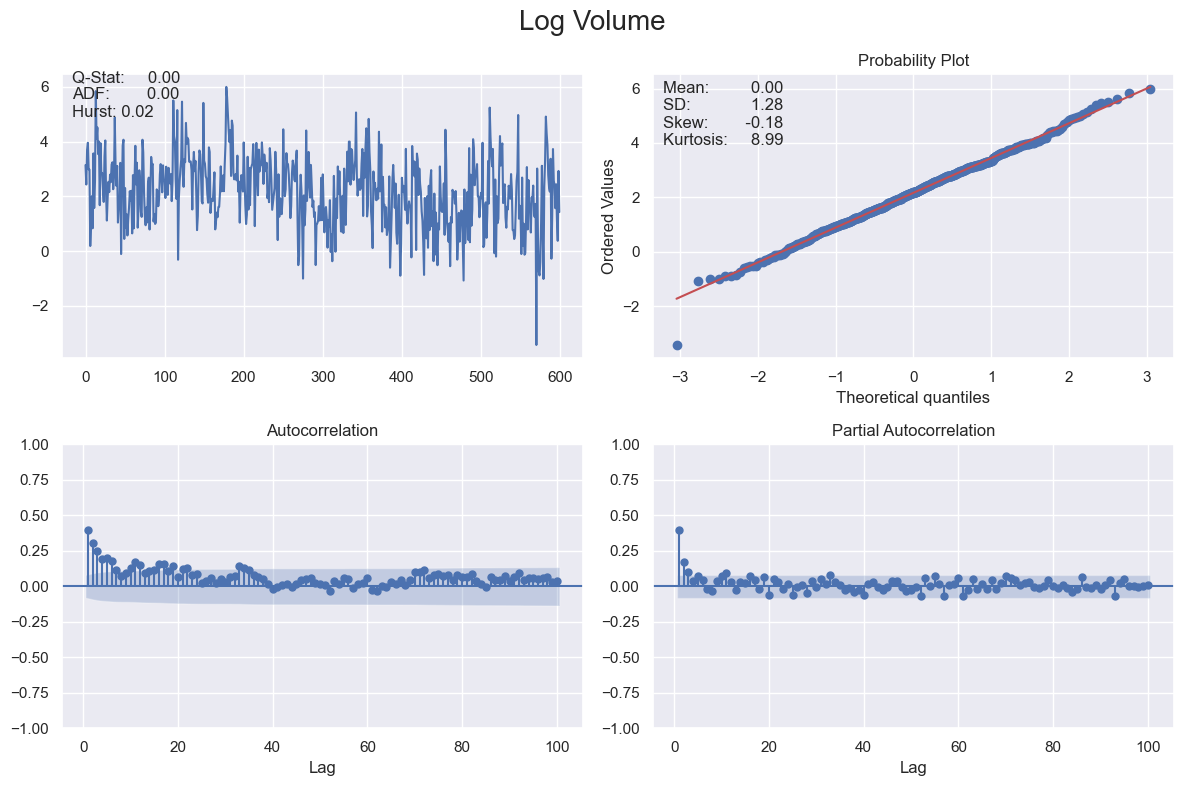

In [105]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(trx_features_cleaned['total_volume'], lags=100, title='Log Volume')

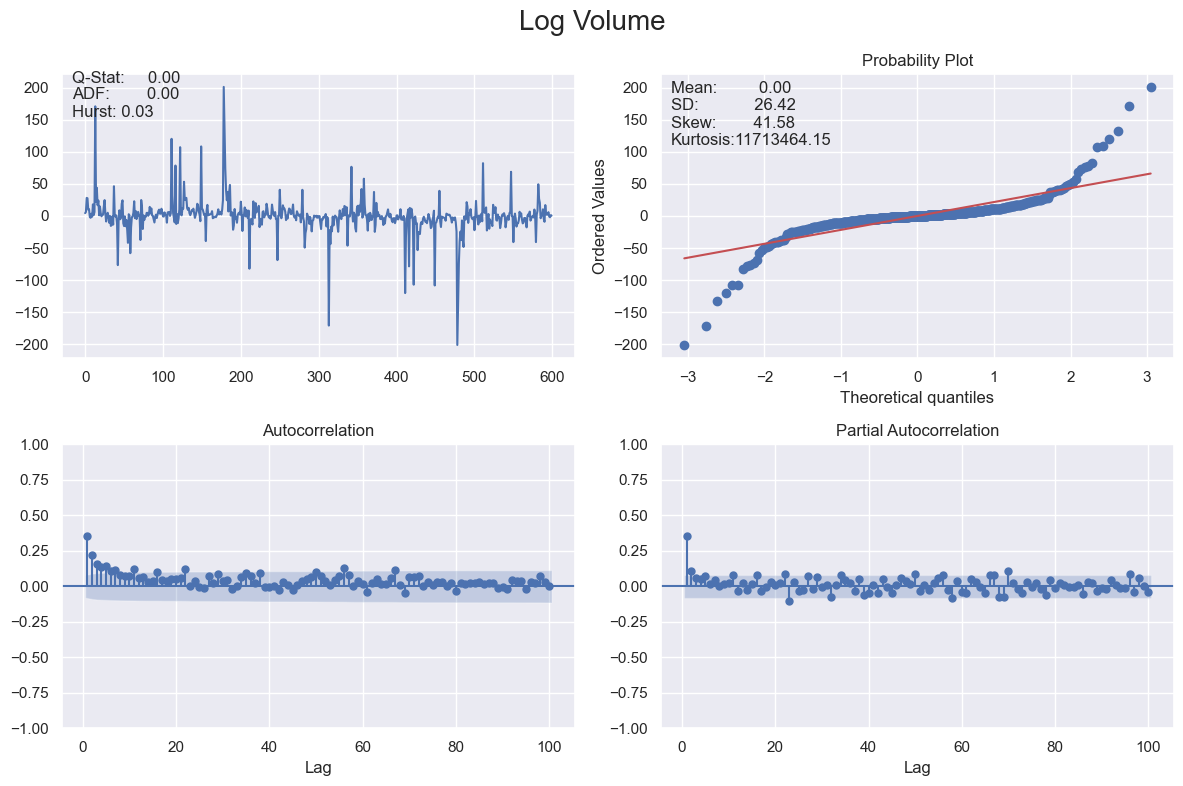

In [104]:

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(trx_features_cleaned['deseasoned_total_volume'], lags=100, title='Log Volume')

In [99]:
# Specify GARCH model assumptions
basic_gm = arch_model(trx_features['deseasoned_total_volume'], p = 1, q = 1,
                      mean = 'ARX', lags=2, vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     38,   Neg. LLF: 2763.5894430653907
Iteration:      8,   Func. Count:     69,   Neg. LLF: 2762.597025123381
Iteration:     12,   Func. Count:     97,   Neg. LLF: 2760.5209384221353
Iteration:     16,   Func. Count:    125,   Neg. LLF: 2759.864098637645
Iteration:     20,   Func. Count:    153,   Neg. LLF: 2759.8631471153276
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2759.8631446285576
            Iterations: 22
            Function evaluations: 167
            Gradient evaluations: 22


In [100]:
print(gm_result.summary())

                              AR - GARCH Model Results                             
Dep. Variable:     deseasoned_total_volume   R-squared:                       0.136
Mean Model:                             AR   Adj. R-squared:                  0.133
Vol Model:                           GARCH   Log-Likelihood:               -2759.86
Distribution:                       Normal   AIC:                           5531.73
Method:                 Maximum Likelihood   BIC:                           5558.09
                                             No. Observations:                  598
Date:                     Fri, Apr 11 2025   Df Residuals:                      595
Time:                             18:31:10   Df Model:                            3
                                  Mean Model                                 
                    coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------------
Const     

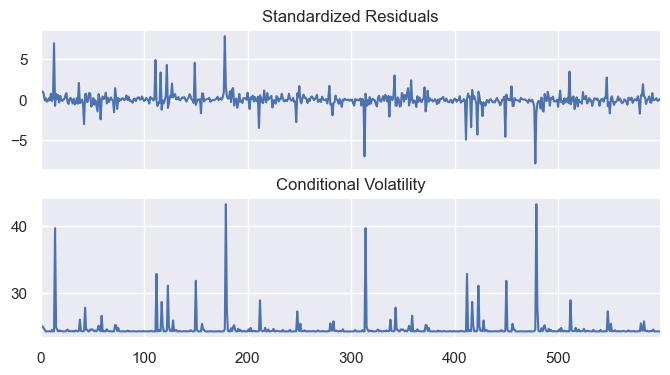

In [101]:
# Plot fitted results
gm_result.plot()
plt.show()

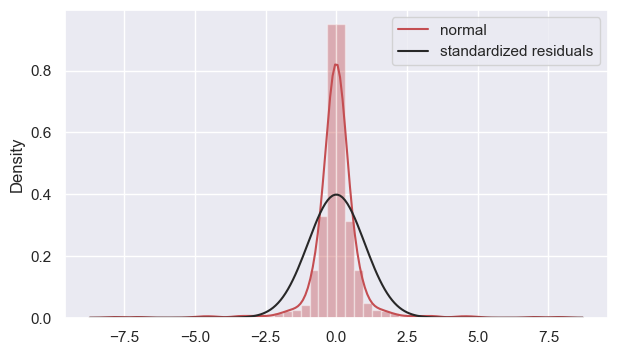

In [102]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

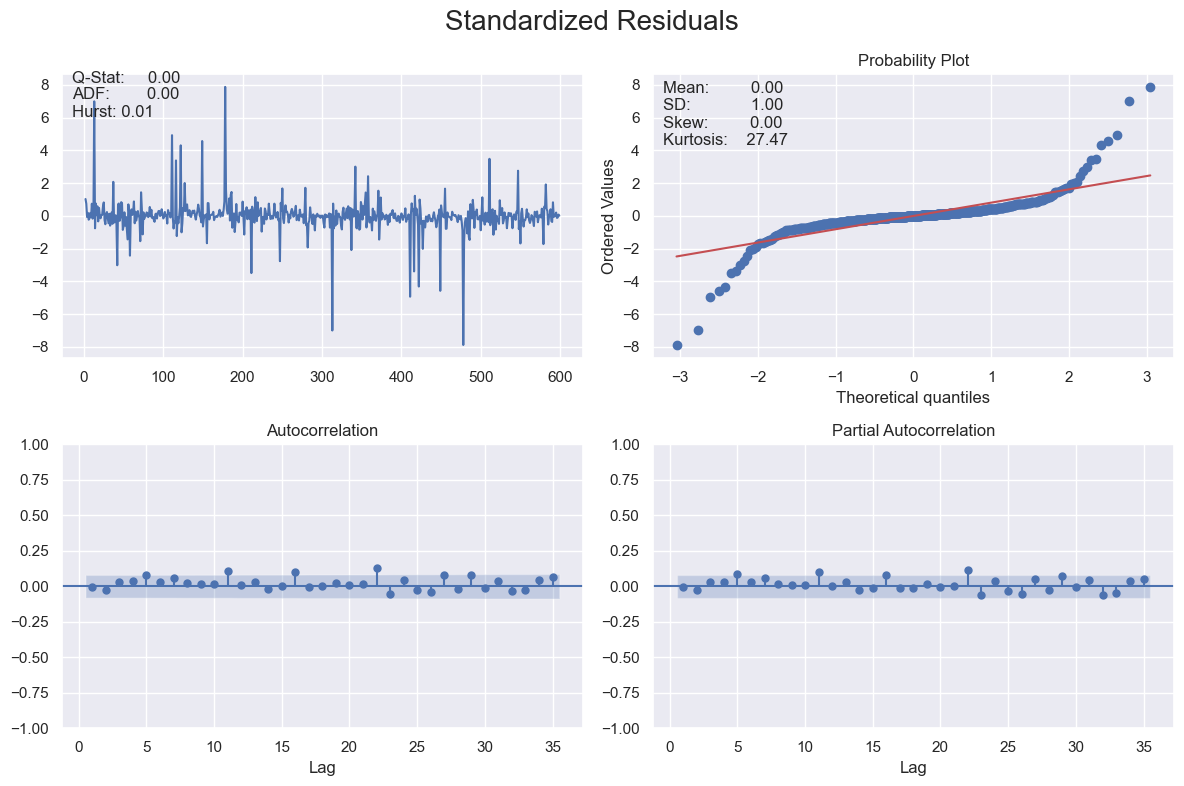

In [103]:
plot_correlogram(gm_std_resid.dropna(), lags=35, title='Standardized Residuals')